In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.model_selection import LeaveOneGroupOut, KFold
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import zscore
import glob


import warnings
warnings.filterwarnings("ignore")

C:\Users\ehall\Anaconda3\envs\beppy\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ehall\Anaconda3\envs\beppy\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ehall\Anaconda3\envs\beppy\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [ ]:
# get number of fixated / non-fixated objects
data = pd.read_csv("data/OM01_MeaningFixatedNonFixated_NoRandomSampling_AllObjects.csv")
#objs = data.groupby(["sbj", "trial"]).mean().reset_index()
#objs["fixated"].std()*28.7
data = pd.read_csv("data/OM01_MeaningFixatedNonFixated_NoRandomSampling_AllObjects.csv")
thirdquartilesize = data["size"].mean() + (.675 * data["size"].std())
#print(thirdquartilesize * (1024*768))
data = data[data["size"] < thirdquartilesize]
data["meaning"] = scale(data["meaning"])
data["salience"] = scale(data["salience"])
data["size"] = scale(data["size"])
data["ecc"] = scale(data["ecc"])
data["fixated"] = data["fixated"].astype(int)

sampled = pd.DataFrame()
for sbj in data.sbj.unique():
    curr_sub = data.loc[data["sbj"] == sbj]
    
    for trial in curr_sub.trial.unique():
        curr_trial = curr_sub[curr_sub["trial"]==trial]
        fixated = curr_trial[curr_trial["fixated"] == 1]
        notfixated = curr_trial[curr_trial["fixated"] == 0]
         
        if len(fixated) & len(notfixated) > 0:
            if len(fixated) < len(notfixated):
                fixated = fixated.sample(n=len(notfixated), replace=True)

            elif len(notfixated) < len(fixated):
                notfixated = notfixated.sample(n=len(fixated), replace=True)
        
            sampled = sampled.append(fixated)
            sampled= sampled.append(notfixated)



print(len(sampled.loc[sampled['fixated']==1]), 'fixated samples,', end=" ")
print(len(sampled.loc[sampled['fixated']==0]), 'not fixated samples')
sampled.to_csv('sampled_allObjects.csv')
print(thirdquartilesize * (1024*768))

data = pd.read_csv("data/OM01_MeaningFixatedNonFixated_NoRandomSampling_NoBackground.csv")
data = data[data["size"] < data["size"].mean() + (.675 * data["size"].std())]
data["meaning"] = scale(data["meaning"])
data["salience"] = scale(data["salience"])
data["size"] = scale(data["size"])
data["ecc"] = scale(data["ecc"])
data["fixated"] = data["fixated"].astype(int)
# need to downsample non-fixated objects
sampled = pd.DataFrame()
for sbj in data.sbj.unique():
    curr_sub = data.loc[data["sbj"] == sbj]
    
    for trial in curr_sub.trial.unique():
        curr_trial = curr_sub[curr_sub["trial"]==trial]
        fixated = curr_trial[curr_trial["fixated"] == 1]
        notfixated = curr_trial[curr_trial["fixated"] == 0]
        
        if len(fixated) & len(notfixated) > 0:
            if len(fixated) < len(notfixated):
                fixated = fixated.sample(n=len(notfixated), replace=True)

            elif len(notfixated) < len(fixated):
                notfixated = notfixated.sample(n=len(fixated), replace=True)
        
            sampled = sampled.append(fixated)
            sampled= sampled.append(notfixated)


print(len(sampled.loc[sampled['fixated']==1]), 'fixated samples,', end=" ")
print(len(sampled.loc[sampled['fixated']==0]), 'not fixated samples')
sampled.to_csv('sampled_nobackgroundObjects.csv')
print(thirdquartilesize * (1024*768))

It runs cv logistic regressions leaving one trial out. The models and their variance are saved, and the unique and shared variances are plotted. I have only included 3 predictive factors as I was following the variance partitioning techniques described here, http://lytarhan.rbind.io/post/variancepartitioning/ and in Groen at al. 2018. Essentially it can become very tricky (and uninterpretable) to partition more than 3 predictors. So two plots are done, the comparison between size, meaning, and salience on fixation, and the comparison between eccentricity meaning and salience on fixation. 

In [12]:
data = pd.read_csv('/Users/ehall/Box Sync/UCD/Projects//Peacock_Objects/Peacock_Objects/beth/data/sampled_allObjects.csv') # this is all objects, upsampled, filtered by size


In [16]:
data.head(5)

,Unnamed: 0,sbj,trial,meaning,salience,size,ecc,fixated
0,1,1,1,-1.242302,0.275981,-0.000379,-1.194308,1
1,2,1,1,-1.159171,-0.186956,-0.179688,-1.494962,1
2,3,1,1,-0.829922,-0.025530,-0.419725,-1.945968,1
3,4,1,1,-1.219084,-0.297414,0.191735,-1.167000,1
4,5,1,1,-1.398522,-0.359620,0.370580,-1.564459,1
...,...,...,...,...,...,...,...,...
212241,242594,100,100,-1.413448,-0.898648,-0.620756,-1.541944,0
212242,242592,100,100,0.262250,-0.872327,-0.605923,-1.024710,0
212243,242590,100,100,-1.878612,-1.190531,0.118372,-1.726515,0
212244,242591,100,100,-0.368732,-0.807940,-0.411907,-1.801375,0


In [ ]:
path = "data/auto_seg_fixate/*.csv"
numobjs =[]
numobjsstd =[]
numfix = []
numfixstd = []
samnumobjs = []
samnumstd = []
samfix = []
samfixstd =[]
models = ['fixated ~ meaning + salience + size',
         'fixated ~ meaning + salience',
         'fixated ~ meaning + size',
         'fixated ~ salience + size',
         'fixated ~ meaning',
         'fixated ~ salience',
         'fixated ~ size']
modelNames = ['m&s&z', 'm&s', 'm&z', 's&z', 'm', 's', 'z']
r2s = []

for fname in glob.glob(path):
    data = pd.read_csv(fname)
    data["meaning"] = scale(data["meaning"])
    data["salience"] = scale(data["salience"])
    data["size"] = scale(data["size"])
    data["ecc"] = scale(data["ecc"])
    data["fixated"] = data["fixated"].astype(int)
    # need to downsample non-fixated objects
    sampled = pd.DataFrame()
    for trial in data.trial.unique():  
        curr_trial = data[data["trial"]==trial]
        fixated = curr_trial[curr_trial["fixated"] == 1]
        notfixated = curr_trial[curr_trial["fixated"] == 0]
        
        if len(fixated) > len(notfixated):  #  it's downsampling now but can be changed to upsample
            fixated = fixated.sample(n=len(notfixated))

        elif len(notfixated) > len(fixated):
            notfixated = notfixated.sample(n=len(fixated))

        
        sampled = sampled.append(fixated)
        sampled= sampled.append(notfixated)

    numobjs.append(data.groupby(["trial"]).count().mean()[0])
    numobjsstd.append(data.groupby(["sbj","trial"]).count().std()[0])
    numfix.append(data[data["fixated"]==1].groupby(["sbj", "trial"]).count().mean()[0])
    numfixstd.append(data[data["fixated"]==1].groupby(["sbj", "trial"]).count().std()[0])
    
    samnumobjs.append(sampled.groupby(["trial"]).count().mean()[0])
    samnumstd.append(sampled.groupby(["trial"]).count().std()[0])
    samfix.append(sampled[sampled["fixated"]==1].groupby(["trial"]).count().mean()[0])
    samfixstd.append(sampled[sampled["fixated"]==1].groupby(["trial"]).count().std()[0])
    
    for model_idx in range(len(models)):
        model = models[model_idx]
        predictions = []
        test = []

        y, X = dmatrices(model, sampled, return_type = 'matrix')
        groups = list(sampled.trial)
        logo = LeaveOneGroupOut()
        for train_index, test_index in logo.split(X,y,groups):    
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            clf = LogisticRegression(random_state=402).fit(X_train, y_train)
            predictions.extend(list(clf.predict(X_test)))
            test.extend(list(y_test[:,0]))

        predictionsArray = np.asarray(predictions)
        testArray = np.asarray(test)
        r = np.corrcoef(predictionsArray, testArray, rowvar = False)[0][1]
        rSign = r/abs(r)
        modelR2 = r**2 * rSign 
        r2s.append(modelR2)

autovar = pd.DataFrame()
autovar["model"] = modelNames * 100
autovar["variance"] = r2s
rSquared = dict(zip(autovar.model, autovar.variance))
size_unique = rSquared['m&s&z'] - rSquared["m&s"] 
meaning_unique = rSquared['m&s&z'] - rSquared['s&z'] 
salience_unique = rSquared['m&s&z'] -  rSquared['m&z']
shared3 = rSquared['m'] + rSquared['s'] + rSquared['z'] - (2*rSquared['m&s&z']) + meaning_unique + size_unique + salience_unique
shared_ms = rSquared['m'] + rSquared['s'] - rSquared['m&s'] - shared3
shared_mz = rSquared['m'] + rSquared['z'] - rSquared['m&z'] - shared3
shared_sz = rSquared['s'] + rSquared['z'] - rSquared['s&z'] - shared3
plotLabels = ['Meaning', 'Salience','Size', 'M. + Sal.', 'M. + Size', 'Sal. + Size']
variances =  [meaning_unique, salience_unique, size_unique, shared_ms, shared_mz, shared_sz]
plt.bar(plotLabels, variances)

plt.xlabel('type of variance')
plt.ylabel('% of variance explained')
plt.xticks(rotation = 45)
plt.title('Example results using standard variance partitioning')
plt.show()    



KeyboardInterrupt: 

running regressions...
m&s&z 64.17
m&s 59.77
m&z 62.22
s&z 62.6
m 57.41
s 57.81
z 58.01


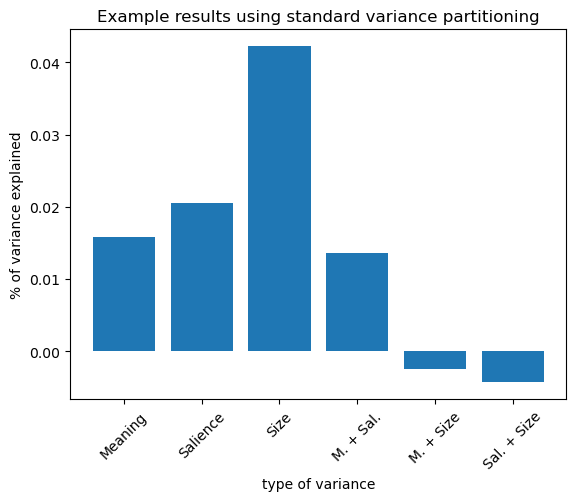

In [15]:
models = ['fixated ~ meaning + salience + size',
         'fixated ~ meaning + salience',
         'fixated ~ meaning + size',
         'fixated ~ salience + size',
         'fixated ~ meaning',
         'fixated ~ salience',
         'fixated ~ size']
modelNames = ['m&s&z', 'm&s', 'm&z', 's&z', 'm', 's', 'z']
rSquared = {};


print('running regressions...')
for model_idx in range(len(models)):
    print(modelNames[model_idx], end=" ")
    model = models[model_idx]
    predictions = []
    test = []

    
    y, X = dmatrices(model, data, return_type = 'matrix')
    groups = list(data.trial)

    for train_index, test_index in logo.split(X,y,groups):    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LogisticRegression(random_state=402).fit(X_train, y_train)
        predictions.extend(list(clf.predict(X_test)))
        test.extend(list(y_test[:,0]))
        
    predictionsArray = np.asarray(predictions)
    testArray = np.asarray(test)
    r = np.corrcoef(predictionsArray, testArray, rowvar = False)[0][1]
    rSign = r/abs(r)
    modelR2 = r**2 * rSign 
    rSquared[modelNames[model_idx]] = modelR2 
    print(round(np.sum(testArray == predictionsArray)/len(testArray)*100, 2))

size_unique = rSquared['m&s&z'] - rSquared["m&s"] 
meaning_unique = rSquared['m&s&z'] - rSquared['s&z'] 
salience_unique = rSquared['m&s&z'] -  rSquared['m&z']
shared3 = rSquared['m'] + rSquared['s'] + rSquared['z'] - (2*rSquared['m&s&z']) + meaning_unique + size_unique + salience_unique
shared_ms = rSquared['m'] + rSquared['s'] - rSquared['m&s'] - shared3
shared_mz = rSquared['m'] + rSquared['z'] - rSquared['m&z'] - shared3
shared_sz = rSquared['s'] + rSquared['z'] - rSquared['s&z'] - shared3
plotLabels = ['Meaning', 'Salience','Size', 'M. + Sal.', 'M. + Size', 'Sal. + Size']
variances =  [meaning_unique, salience_unique, size_unique, shared_ms, shared_mz, shared_sz]
plt.bar(plotLabels, variances)

plt.xlabel('type of variance')
plt.ylabel('% of variance explained')
plt.xticks(rotation = 45)
plt.title('Example results using standard variance partitioning')
plt.show()



running regressions...
m&s&e 65.13
m&s 59.87
m&e 64.61
s&e 64.65
m 57.42
s 57.83
e 64.01


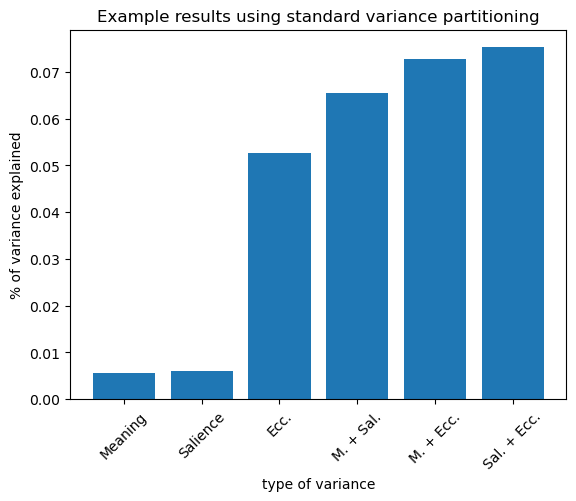

In [18]:
models = ['fixated ~ meaning + salience + ecc',
         'fixated ~ meaning + salience',
         'fixated ~ meaning + ecc',
         'fixated ~ salience + ecc',
         'fixated ~ meaning',
         'fixated ~ salience',
         'fixated ~ ecc']
modelNames = ['m&s&e', 'm&s', 'm&e', 's&e', 'm', 's', 'e']
rSquared = {};


print('running regressions...')
for model_idx in range(len(models)):
    print(modelNames[model_idx], end=" ")
    model = models[model_idx]
    predictions = []
    test = []

    
    y, X = dmatrices(model, data, return_type = 'matrix')
    groups = list(data.sbj)

    for train_index, test_index in logo.split(X,y,groups):    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LogisticRegression(random_state=42).fit(X_train, y_train)
        predictions.extend(list(clf.predict(X_test)))
        test.extend(list(y_test[:,0]))
        
    predictionsArray = np.asarray(predictions)
    testArray = np.asarray(test)
    r = np.corrcoef(predictionsArray, testArray, rowvar = False)[0][1]
    rSign = r/abs(r)
    modelR2 = r**2 * rSign 
    rSquared[modelNames[model_idx]] = modelR2 
    print(round(np.sum(testArray == predictionsArray)/len(testArray)*100, 2))

ecc_unique = rSquared['m&s&e'] - rSquared["m&s"] 
meaning_unique = rSquared['m&s&e'] - rSquared['s&e'] 
salience_unique = rSquared['m&s&e'] -  rSquared['m&e']
shared3 = rSquared['m'] + rSquared['s'] + rSquared['e'] - (2*rSquared['m&s&e']) 
+ meaning_unique + ecc_unique + salience_unique

shared_ms = rSquared['m'] + rSquared['s'] - rSquared['m&s'] - shared3
shared_me = rSquared['m'] + rSquared['e'] - rSquared['m&e'] - shared3
shared_se = rSquared['s'] + rSquared['e'] - rSquared['s&e'] - shared3
plotLabels = ['Meaning', 'Salience','Ecc.', 'M. + Sal.', 'M. + Ecc.', 'Sal. + Ecc.']
variances =  [meaning_unique, salience_unique, ecc_unique, shared_ms, shared_me, shared_se]
plt.bar(plotLabels, variances)
plt.xlabel('type of variance')
plt.ylabel('% of variance explained')
plt.xticks(rotation = 45)
plt.title('Example results using standard variance partitioning')
plt.show()
